# Dayfile read

In [65]:
import os
import struct
import sys

import pandas as pd

sys.path.append('../../')
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import tdx_data_Day as tdd
from JSONData import sina_data


In [93]:
import pandas as pd

def detect_bullish_breakout(df, 
                            price_col='close', 
                            high_col='high', 
                            low_col='low', 
                            upper_col='upper', 
                            mid_col='ene', 
                            ma26_col='ma20d',
                            lookback=60):
    """
    识别多头爆发形态：
    1. 最近 lookback 天内至少一次冲击过上轨 upper
    2. 回落时没有有效跌破 mid
    3. 当前价格重新突破 upper（二次突破）
    4. 站上 ma26，且突破近期高点
    
    返回: 一个 Series，标记每个交易日是否符合形态
    """

    price = df[price_col]
    high = df[high_col]
    low = df[low_col]
    upper = df[upper_col]
    mid = df[mid_col]
    ma26 = df[ma26_col]

    signals = pd.Series(False, index=df.index)

    for i in range(lookback, len(df)):
        window = df.iloc[i-lookback:i+1]

        # Step 1: 曾经冲击过上轨
        cond1 = (window[high_col].iloc[:-5] > window[upper_col].iloc[:-5]).any()

        # Step 2: 回落时守住 mid
        cond2 = (window[low_col].iloc[:-5].min() > window[mid_col].iloc[:-5].min())

        # Step 3: 当前突破 upper
        cond3 = window[price_col].iloc[-1] > window[upper_col].iloc[-1]

        # Step 4: 当前在 ma26 上方
        cond4 = window[price_col].iloc[-1] > window[ma26_col].iloc[-1]

        # Step 5: 突破近期高点
        recent_high = window[high_col].iloc[:-1].max()
        cond5 = window[price_col].iloc[-1] > recent_high

        if cond1 and cond2 and cond3 and cond4 and cond5:
            signals.iloc[i] = True

    return signals


In [98]:
# code='000009'
code='600895'
df = tdd.get_tdx_Exp_day_to_df(code,dl=ct.duration_date_day*2,resample='d',lastday=None )

In [99]:
df['bullish_breakout'] = detect_bullish_breakout(df)

In [100]:
# df.bullish_breakout[-60:]
# df
# df.loc[:,['open','high','close','low','upper','ene','lower']][-60:]
df['volume'] = df['vol']
print(df[df['bullish_breakout']])

              code   open   high    low  close          vol        amount  \
date                                                                        
2025-07-23  600895  26.85  28.26  26.59  27.60   96611688.0  2.677905e+09   
2025-07-25  600895  27.81  30.43  27.43  30.43  132522816.0  3.885476e+09   
2025-07-28  600895  30.44  31.92  29.96  31.13  144499264.0  4.488031e+09   
2025-07-30  600895  31.35  34.74  31.20  33.84  157260592.0  5.159315e+09   
2025-09-22  600895  39.28  42.56  38.53  41.97  174785009.0  7.161353e+09   
2025-09-23  600895  41.00  46.16  40.88  46.16  182127269.0  7.782296e+09   
2025-09-24  600895  47.00  50.78  46.19  50.78  143548982.0  6.997043e+09   
2025-09-25  600895  52.00  55.00  50.19  52.16  227957616.0  1.196555e+10   

            lower   ene  upper  ...   hmax  hmax60  high4     llowvol  low10  \
date                            ...                                            
2025-07-23   24.4  25.8   27.2  ...  27.06   27.06  27.06  33598091.0

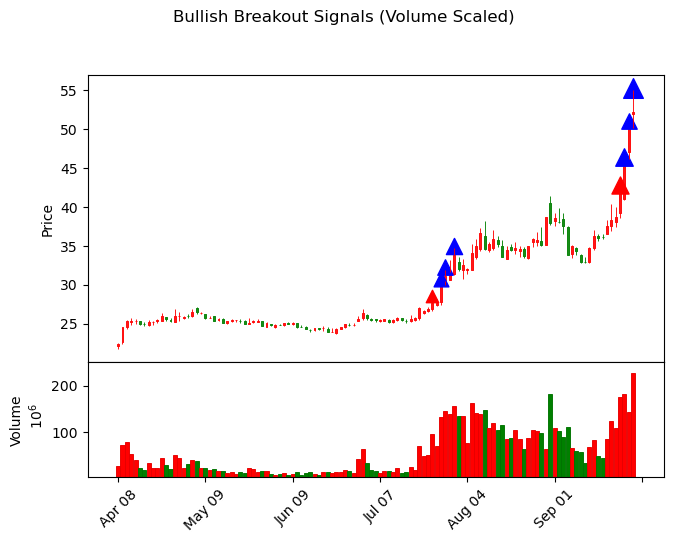

In [101]:
import pandas as pd
import numpy as np
import mplfinance as mpf

def plot_bullish_breakout(df, bullish_col='bullish_breakout', gap=5, offset=0.3, min_size=80, max_size=200):
    """
    绘制多头爆发信号，红色表示第一次冲击，蓝色表示第二次爆发。
    箭头大小随成交量变化。
    
    df: 日K线数据，必须包含 'open','high','low','close','vol' 和 bullish_col
    bullish_col: 信号列，True表示信号
    gap: 两次信号间隔交易日数区分第一次/第二次
    offset: 箭头在K线上方偏移量
    min_size, max_size: 箭头最小和最大大小
    """
    df_plot = df.copy()
    df_plot.index = pd.to_datetime(df_plot.index)

    mc = mpf.make_marketcolors(up='red', down='green', edge='i', wick='i', volume='in')
    s = mpf.make_mpf_style(marketcolors=mc)

    # 找到信号点索引
    signal_idx = df_plot[df_plot[bullish_col]].index
    signal_pos = df_plot.index.get_indexer(signal_idx)
    
    if len(signal_idx) == 0:
        # 没有信号直接绘制K线
        mpf.plot(df_plot, type='candle', style=s, volume=True,
                 title="Bullish Breakout Signals", ylabel="Price", ylabel_lower="Volume")
        return

    # 计算每个信号的箭头大小
    vol_signal = df_plot.loc[signal_idx, 'vol']
    vol_min, vol_max = vol_signal.min(), vol_signal.max()
    markersizes = min_size + (vol_signal - vol_min) / (vol_max - vol_min) * (max_size - min_size)

    # 根据 gap 区分第一次/第二次突破
    colors = []
    last_pos = -gap*2
    for pos in signal_pos:
        if pos - last_pos > gap:
            colors.append('r')  # 第一次冲击
        else:
            colors.append('b')  # 第二次爆发
        last_pos = pos

    # 生成 addplot，每个信号点对应一个 scatter
    ap = []
    for i, idx in enumerate(signal_idx):
        price_series = pd.Series(np.nan, index=df_plot.index)
        price_series[idx] = df_plot.loc[idx, 'high'] + offset
        ap.append(
            mpf.make_addplot(price_series, type='scatter',
                             markersize=markersizes.iloc[i], marker='^', color=colors[i])
        )

    # 绘制
    mpf.plot(df_plot, type='candle', style=s, addplot=ap,
             volume=True, title="Bullish Breakout Signals (Volume Scaled)",
             ylabel="Price", ylabel_lower="Volume")




# 使用示例
plot_bullish_breakout(df)


In [56]:
import pandas as pd
import numpy as np

def track_bullish_strategy(df, bullish_col='bullish_breakout', gap=5, stop_loss_pct=0.05, take_profit_pct=0.15):
    """
    df: 日K线数据，必须包含 ['open','high','low','close','vol', bullish_col]
    bullish_col: 信号列
    gap: 两次信号交易日间隔区分第一次/第二次突破
    stop_loss_pct: 止损比例
    take_profit_pct: 止盈比例
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # 初始化信号列
    df['bullish_first'] = False
    df['bullish_second'] = False
    df['signal_status'] = None
    df['entry_price'] = np.nan
    df['stop_loss'] = np.nan
    df['take_profit'] = np.nan
    df['alert'] = False

    # 找到所有信号点
    signal_idx = df[df[bullish_col]].index
    signal_pos = df.index.get_indexer(signal_idx)

    if len(signal_idx) == 0:
        return df

    # 根据 gap 区分第一次/第二次突破
    last_pos = -gap*2
    for pos, idx in zip(signal_pos, signal_idx):
        if pos - last_pos > gap:
            df.loc[idx, 'bullish_first'] = True
            df.loc[idx, 'signal_status'] = 'observing'
        else:
            df.loc[idx, 'bullish_second'] = True
            df.loc[idx, 'signal_status'] = 'holding'
            entry_price = df.loc[idx, 'close']
            df.loc[idx, 'entry_price'] = entry_price
            df.loc[idx, 'stop_loss'] = entry_price * (1 - stop_loss_pct)
            df.loc[idx, 'take_profit'] = entry_price * (1 + take_profit_pct)
            df.loc[idx, 'alert'] = True  # 触发买入预警
        last_pos = pos

    # 持仓跟踪
    holding = False
    entry_price = None
    stop_loss = None
    take_profit = None
    for idx, row in df.iterrows():
        # 持仓状态更新
        if row['signal_status'] == 'holding':
            holding = True
            entry_price = row['entry_price']
            stop_loss = row['stop_loss']
            take_profit = row['take_profit']

        if holding:
            # 检查止损
            if row['low'] <= stop_loss:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True  # 止损提醒
                holding = False
            # 检查止盈
            elif row['high'] >= take_profit:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True  # 止盈提醒
                holding = False

    return df


In [57]:
# print(df.columns.tolist())

In [58]:
# df 是你的日K线数据，包含 bullish_breakout 列
df_tracked = track_bullish_strategy(df)

# 查看触发预警的日期
alerts = df_tracked[df_tracked['alert']]
print(alerts[['bullish_first','bullish_second','signal_status','entry_price','stop_loss','take_profit']])


Empty DataFrame
Columns: [bullish_first, bullish_second, signal_status, entry_price, stop_loss, take_profit]
Index: []


In [59]:
import pandas as pd
import numpy as np

def track_bullish_signals(df, breakout_col='bullish_breakout', gap=5, stop_loss_pct=0.05, take_profit_pct=0.15):
    """
    自动识别第一次冲击（观察期）和第二次爆发（建仓期），并持续跟踪持仓
    df: 日K线数据，必须包含 ['open','high','low','close', breakout_col]
    breakout_col: 原始突破信号列
    gap: 两次突破的最小间隔天数，用于区分第一次/第二次突破
    stop_loss_pct: 止损比例
    take_profit_pct: 止盈比例
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # 初始化列
    df['bullish_first'] = False
    df['bullish_second'] = False
    df['signal_status'] = None
    df['entry_price'] = np.nan
    df['stop_loss'] = np.nan
    df['take_profit'] = np.nan
    df['alert'] = False

    # 找到所有突破信号
    signal_idx = df[df[breakout_col]].index
    signal_pos = df.index.get_indexer(signal_idx)
    last_pos = -gap*2

    # 区分第一次和第二次突破
    for pos, idx in zip(signal_pos, signal_idx):
        if pos - last_pos > gap:
            df.loc[idx, 'bullish_first'] = True
            df.loc[idx, 'signal_status'] = 'observing'
            df.loc[idx, 'alert'] = True  # 观察预警
        else:
            df.loc[idx, 'bullish_second'] = True
            df.loc[idx, 'signal_status'] = 'holding'
            entry_price = df.loc[idx, 'close']
            df.loc[idx, 'entry_price'] = entry_price
            df.loc[idx, 'stop_loss'] = entry_price * (1 - stop_loss_pct)
            df.loc[idx, 'take_profit'] = entry_price * (1 + take_profit_pct)
            df.loc[idx, 'alert'] = True  # 建仓预警
        last_pos = pos

    # 持仓跟踪
    holding = False
    entry_price = None
    stop_loss = None
    take_profit = None

    for idx, row in df.iterrows():
        if row['bullish_second']:
            holding = True
            entry_price = row['entry_price']
            stop_loss = row['stop_loss']
            take_profit = row['take_profit']

        if holding:
            # 检查止损
            if row['low'] <= stop_loss:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True
                holding = False
            # 检查止盈
            elif row['high'] >= take_profit:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True
                holding = False

    return df


In [60]:
# df 是你的日K线数据，包含 bullish_breakout 列
df_tracked = track_bullish_signals(df)

# 查看触发预警的日期
alerts = df_tracked[df_tracked['alert']]
print(alerts[['bullish_first','bullish_second','signal_status','entry_price','stop_loss','take_profit']])


            bullish_first  bullish_second signal_status  entry_price  \
date                                                                   
2025-07-28           True           False     observing          NaN   
2025-09-25           True           False     observing          NaN   

            stop_loss  take_profit  
date                                
2025-07-28        NaN          NaN  
2025-09-25        NaN          NaN  


In [61]:
print(df[df['bullish_breakout']])

              code   open   high    low  close          vol        amount  \
date                                                                        
2025-07-28  000009   9.04   9.39   8.97   9.30   58055792.0  5.362302e+08   
2025-09-25  000009  11.56  12.28  11.56  12.08  218314141.0  2.637727e+09   

            lower   ene  upper  ...   hmax  hmax60  high4     llowvol  low10  \
date                            ...                                            
2025-07-28    8.6   8.9    9.2  ...   9.10    9.10   9.03  20133824.0   8.64   
2025-09-25    9.3  10.6   11.9  ...  11.38   11.38  11.32  20133824.0  10.02   

            low60   low4  lastdu4  bullish_breakout       volume  
date                                                              
2025-07-28   8.68   8.70      6.0              True   58055792.0  
2025-09-25   8.68  10.02     20.6              True  218314141.0  

[2 rows x 202 columns]


import pandas as pd
import numpy as np

def track_bullish_signals1(df,  breakout_col='bullish_breakout', gap=5, stop_loss_pct=0.05, take_profit_pct=0.15):
    """
    持续跟踪 bullish_first 和 bullish_second 信号，生成持仓状态和预警
    df: 日K线数据，必须包含 ['open','high','low','close','bullish_first','bullish_second']
    stop_loss_pct: 止损比例
    take_profit_pct: 止盈比例
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # 初始化
    df['signal_status'] = None
    df['entry_price'] = np.nan
    df['stop_loss'] = np.nan
    df['take_profit'] = np.nan
    df['alert'] = False

    holding = False
    entry_price = None
    stop_loss = None
    take_profit = None
    
        # 找到所有突破信号
    signal_idx = df[df[breakout_col]].index
    signal_pos = df.index.get_indexer(signal_idx)
    last_pos = -gap*2
    # 区分第一次和第二次突破
    for pos, idx in zip(signal_pos, signal_idx):
        if pos - last_pos > gap:
            df.loc[idx, 'bullish_first'] = True
            df.loc[idx, 'signal_status'] = 'observing'
            df.loc[idx, 'alert'] = True  # 观察预警
        else:
            df.loc[idx, 'bullish_second'] = True
            df.loc[idx, 'signal_status'] = 'holding'
            entry_price = df.loc[idx, 'close']
            df.loc[idx, 'entry_price'] = entry_price
            df.loc[idx, 'stop_loss'] = entry_price * (1 - stop_loss_pct)
            df.loc[idx, 'take_profit'] = entry_price * (1 + take_profit_pct)
            df.loc[idx, 'alert'] = True  # 建仓预警
        last_pos = pos
    for idx, row in df.iterrows():
        # 第一次冲击 → 观察期
        if row['bullish_first']:
            df.loc[idx, 'signal_status'] = 'observing'
            df.loc[idx, 'alert'] = True  # 观察预警

        # 第二次爆发 → 建仓
        if row['bullish_second']:
            df.loc[idx, 'signal_status'] = 'holding'
            entry_price = row['close']
            stop_loss = entry_price * (1 - stop_loss_pct)
            take_profit = entry_price * (1 + take_profit_pct)
            df.loc[idx, 'entry_price'] = entry_price
            df.loc[idx, 'stop_loss'] = stop_loss
            df.loc[idx, 'take_profit'] = take_profit
            df.loc[idx, 'alert'] = True  # 建仓预警
            holding = True

        # 持仓跟踪
        if holding:
            # 检查止损
            if row['low'] <= stop_loss:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True  # 止损提醒
                holding = False
            # 检查止盈
            elif row['high'] >= take_profit:
                df.loc[idx, 'signal_status'] = 'closed'
                df.loc[idx, 'alert'] = True  # 止盈提醒
                holding = False

    return df


# df 是你已有的 DataFrame，包含 bullish_first 和 bullish_second
df_tracked = track_bullish_signals(df)

# 查看触发预警的日期和状态
alerts = df_tracked[df_tracked['alert']]
print(alerts[['bullish_first','bullish_second','signal_status','entry_price','stop_loss','take_profit']])


def readTdxLdayFile(fname="D:\\MacTools\\WinTools\\new_tdx\\vipdoc\\sh\\lday\\sh601628.day"):
    dataSet = []
    with open(fname, 'rb') as fl:
        buffer = fl.read()  # 读取数据到缓存
        size = len(buffer)
        rowSize = 32  # 通信达day数据，每32个字节一组数据
        code = os.path.basename(fname).replace('.day', '')
        for i in range(0, size, rowSize):  # 步长为32遍历buffer
            row = list(struct.unpack('IIIIIfII', buffer[i:i + rowSize]))
            row[0] = (cct.day8_to_day10(row[0]))
            row[1] = row[1] / 100
            row[2] = row[2] / 100
            row[3] = row[3] / 100
            row[4] = row[4] / 100
            row.pop()  # 移除最后无意义字段
            row.insert(0, code)
            dataSet.append(row)
    data = pd.DataFrame(data=dataSet, columns=[
                        'code', 'tradeDate', 'open', 'high', 'low', 'close', 'amount', 'vol'])
    print(data[-2:])



In [13]:
# readTdxLdayFile()

In [14]:
# df= tdd.get_tdx_Exp_day_to_df_AllRead_('601628', dl=800, resample='d').sort_index(ascending=True)

# print(df[-1:],df.shape)

AttributeError: module 'JSONData.tdx_data_Day' has no attribute 'get_tdx_Exp_day_to_df_AllRead_'

In [15]:
df= tdd.get_tdx_Exp_day_to_df('601628', dl=80, resample='d').sort_index(ascending=True)
print(df[-1:],df.shape)

              code  open   high    low  close        vol       amount  lower  \
date                                                                           
2025-09-25  601628  38.0  38.16  37.69   38.0  9020604.0  342681920.0   37.2   

             ene  upper  ...   max5  max10   hmax  hmax60  high4     llowvol  \
date                     ...                                                   
2025-09-25  39.4   41.6  ...  38.69  39.66  42.92   42.92  38.25  11336811.0   

            low10  low60  low4  lastdu4  
date                                     
2025-09-25   37.5  39.69  37.5      2.4  

[1 rows x 200 columns] (80, 200)


# tdx 2
https://gist.github.com/WMJi/f5fe3083961d26fbfbcc
https://www.cnblogs.com/yuyanc/p/16867362.html

In [ ]:
from struct import *

fname = "D:\\MacTools\\WinTools\\new_tdx\\vipdoc\\sh\\lday\\sh601628.day"
ofile = open(fname, 'rb')
buf = ofile.read()
ofile.close()

# ifile=open('sz000680.txt','w')
num = len(buf)
no = num / 32
b = 0
e = 32
line = ''
dataSet = []
# row=[]
for i in range(int(no)):
    code = os.path.basename(fname).replace('.day', '')
    a = list(unpack('IIIIIfII', buf[b:e]))
    # line=str(a[0])+' '+str(a[1]/100.0)+' '+str(a[2]/100.0)+' '+str(a[3]/100.0)+' '+str(a[4]/100.0)+' '+str(a[5]/10.0)+' '+str(a[6])+' '+str(a[7])+' '+'\n'
    # print(line)
    row = a
    row[0] = (a[0])
    row[1] = (a[1] / 100.0)
    row[2] = (a[2] / 100.0)
    row[3] = (a[3] / 100.0)
    row[4] = (a[4] / 100.0)
    row.pop()
    row.insert(0, code)
    # ifile.write(line)
    b = b + 32
    e = e + 32
    dataSet.append(row)
data = pd.DataFrame(data=dataSet, columns=[
                    'code', 'tradeDate', 'open', 'high', 'low', 'close', 'amount', 'vol'])
print(data)

## 多索引日线数据

In [66]:
code_list = sina_data.Sina().market('all').index.tolist()
code_list.extend(['999999','399001','399006'])
print("all code:",len(code_list))
duration = 300

if duration <= 300 :
    h5_fname = 'tdx_all_df' + '_' + str(300)
    h5_table = 'all' + '_' + str(300)
else:
    h5_fname = 'tdx_all_df' + '_' + str(900)
    h5_table = 'all' + '_' + str(900) 
    
    
df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date')

all code: 5200


### 处理

In [67]:
import pandas as pd

# 假设 df 是大表，index=['code','date']
df = df.sort_index(level=['code','date'])

# 批量计算简单移动平均
for ma in [5,10,20,60]:
    df[f'ma{ma}'] = df.groupby(level='code')['close'].transform(lambda x: x.rolling(ma).mean())

# 批量计算 MACD
def calc_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    dif = ema_fast - ema_slow
    dea = dif.ewm(span=signal).mean()
    macd = 2*(dif - dea)
    return macd

df['macd'] = df.groupby(level='code')['close'].transform(calc_macd)

# 批量生成 macdlast1~6
for i in range(6):
    df[f'macdlast{i+1}'] = df.groupby(level='code')['macd'].shift(i)


In [69]:
# df.loc['000001']

,open,high,low,close,vol,amount,ma5,ma10,ma20,ma60,macd,macdlast1,macdlast2,macdlast3,macdlast4,macdlast5,macdlast6
date,,,,,,,,,,,,,,,,,
2023-11-02,9.54,9.64,9.51,9.52,61942996.0,6.523167e+08,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2023-11-03,9.53,9.56,9.47,9.52,70546344.0,7.388797e+08,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2023-11-06,9.55,9.73,9.55,9.73,100706224.0,1.069207e+09,NaN,NaN,NaN,NaN,0.007686,0.007686,0.000000,0.000000,NaN,NaN,NaN
2023-11-07,9.70,9.70,9.62,9.64,64086612.0,6.798156e+08,NaN,NaN,NaN,NaN,0.004491,0.004491,0.007686,0.000000,0.000000,NaN,NaN
2023-11-08,9.62,9.64,9.49,9.54,87781872.0,9.236220e+08,9.590,NaN,NaN,NaN,-0.002957,-0.002957,0.004491,0.007686,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-19,11.41,11.51,11.37,11.45,83465120.0,9.550041e+08,11.558,11.658,11.8330,12.187500,-0.054399,-0.054399,-0.050772,-0.028503,-0.033521,-0.034924,-0.032598
2025-09-22,11.44,11.47,11.37,11.38,59640232.0,6.801585e+08,11.504,11.626,11.7795,12.180500,-0.060069,-0.060069,-0.054399,-0.050772,-0.028503,-0.033521,-0.034924
2025-09-23,11.37,11.58,11.32,11.52,134143024.0,1.543271e+09,11.480,11.603,11.7375,12.176500,-0.039781,-0.039781,-0.060069,-0.054399,-0.050772,-0.028503,-0.033521


In [77]:
def compute_bollinger(df, n=20, k=2):
    """
    df: 单只股票日线数据，必须包含 'close'
    n: 计算均线窗口
    k: 标准差倍数
    返回带有 ['ma', 'upper', 'lower'] 的 df
    """
    df = df.copy()
    df['ma'] = df['close'].rolling(n).mean()
    df['std'] = df['close'].rolling(n).std()
    df['upper'] = df['ma'] + k * df['std']
    df['lower'] = df['ma'] - k * df['std']
    return df.drop(columns=['std'])


def compute_bullish_breakout(df_stock):
    df_stock = df_stock.copy()
    df_stock = compute_bollinger(df_stock, n=20, k=2)  # 先计算 upper
    # 示例：高点突破上轨 或者 高于最近4日高点
    df_stock['high4'] = df_stock['high'].rolling(4).max()
    df_stock['bullish_breakout'] = (df_stock['high'] > df_stock['high4']) | (df_stock['high'] > df_stock['upper'])
    return df_stock



In [79]:
def generate_bullish_breakout_multi(df):
    df_signal = []
    for code, df_stock in df.groupby(level='code'):
        df_tracked = compute_bullish_breakout(df_stock)
        df_signal.append(df_tracked[['upper','high4','bullish_breakout']])
    return pd.concat(df_signal)

df_signal = generate_bullish_breakout_multi(df)
df = df.join(df_signal)


In [87]:
def track_bullish_signals2(df, breakout_col='bullish_breakout', gap=5, stop_loss_pct=0.05, take_profit_pct=0.15):
    df = df.copy()

    # 如果是 MultiIndex
    if isinstance(df.index, pd.MultiIndex):
        # 假设索引顺序是 ['code','date']
        df = df.reset_index()
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index(['code','date'])
    else:
        df.index = pd.to_datetime(df.index)

    # 后面初始化列和信号跟踪逻辑不变
    df['bullish_first'] = False
    df['bullish_second'] = False
    df['signal_status'] = None
    df['entry_price'] = np.nan
    df['stop_loss'] = np.nan
    df['take_profit'] = np.nan
    df['alert'] = False

    holding = False
    entry_price = None
    stop_loss = None
    take_profit = None
    
    # 找到所有突破信号
    signal_idx = df[df[breakout_col]].index
    signal_pos = df.index.get_indexer(signal_idx)
    last_pos = -gap*2

    # 区分第一次和第二次突破
    for pos, idx in zip(signal_pos, signal_idx):
        if pos - last_pos > gap:
            df.loc[idx, 'bullish_first'] = True
            df.loc[idx, 'signal_status'] = 'observing'
            df.loc[idx, 'alert'] = True
        else:
            df.loc[idx, 'bullish_second'] = True
            df.loc[idx, 'signal_status'] = 'holding'
            entry_price = df.loc[idx, 'close']
            df.loc[idx, 'entry_price'] = entry_price
            df.loc[idx, 'stop_loss'] = entry_price * (1 - stop_loss_pct)
            df.loc[idx, 'take_profit'] = entry_price * (1 + take_profit_pct)
            df.loc[idx, 'alert'] = True
        last_pos = pos

    return df


In [81]:
def track_bullish_signals_multi(df):
    df = df.copy()
    for code, df_stock in df.groupby(level='code'):
        df_tracked = track_bullish_signals(df_stock, breakout_col='bullish_breakout')
        for col in ['bullish_first','bullish_second','signal_status','entry_price','stop_loss','take_profit','alert']:
            df.loc[df_tracked.index, col] = df_tracked[col]
    return df


In [92]:
df = track_bullish_signals_multi(df)

In [91]:
# df_signals = df[(df['bullish_first']) | (df['bullish_second'])]
df.loc['600895'].columns

Index(['open', 'high', 'low', 'close', 'vol', 'amount', 'ma5', 'ma10', 'ma20',
       'ma60', 'macd', 'macdlast1', 'macdlast2', 'macdlast3', 'macdlast4',
       'macdlast5', 'macdlast6', 'upper', 'high4', 'bullish_breakout'],
      dtype='object')

In [85]:
print(f'df_signals : {df_signals}')

df_signals :               code   open   high    low  close          vol        amount  \
date                                                                        
2025-07-28  000009   9.04   9.39   8.97   9.30   58055792.0  5.362302e+08   
2025-09-25  000009  11.56  12.28  11.56  12.08  218314141.0  2.637727e+09   

            lower   ene  upper  ...  lastdu4  bullish_breakout       volume  \
date                            ...                                           
2025-07-28    8.6   8.9    9.2  ...      6.0              True   58055792.0   
2025-09-25    9.3  10.6   11.9  ...     20.6              True  218314141.0   

            bullish_first  bullish_second  signal_status  entry_price  \
date                                                                    
2025-07-28           True           False      observing          NaN   
2025-09-25           True           False      observing          NaN   

            stop_loss  take_profit  alert  
date                    